In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import keras
import nltk
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer,wordnet
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import keras
from keras import layers
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
# Run in case warnings should be ignored
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth',300)


In [2]:
# i want to classify text with RNN (Recurrant Neural Network)
# get data from txt-file
'''Wiki_article_ID
Freebase_ID
Book_title
Author
Publication_date
Book_genres (Freebase ID:name tuples)
Plot_summary'''
df01 = pd.read_csv('booksummaries.txt', sep="\t", header=None)
df01.columns = ['Wiki_article_ID', 'Freebase_ID', 'Book_title', 'Author','Publication_date','Book_genres','Plot_summary']


In [3]:
df01.head(3)

,Wiki_article_ID,Freebase_ID,Book_title,Author,Publication_date,Book_genres,Plot_summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"": ""Satire"", ""/m/0dwly"": ""Children's literature"", ""/m/014dfn"": ""Speculative fiction"", ""/m/02xlf"": ""Fiction""}","Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, 'Beasts of England'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a p..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""Novella"", ""/m/014dfn"": ""Speculative fiction"", ""/m/0c082"": ""Utopian and dystopian fiction"", ""/m/06nbt"": ""Satire"", ""/m/02xlf"": ""Fiction""}","Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random ""ultra-violence."" Alex's friends (""droogs"" in the novel's Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang's muscle; Georgie, an ambitious second-in-command; and..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fiction"", ""/m/0pym5"": ""Absurdist fiction"", ""/m/05hgj"": ""Novel""}","The text of The Plague is divided into five parts. In the town of Oran, thousands of rats, initially unnoticed by the populace, begin to die in the streets. A hysteria develops soon afterward, causing the local newspapers to report the incident. Authorities responding to public pressure order t..."


In [4]:
df01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16559 entries, 0 to 16558
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Wiki_article_ID   16559 non-null  int64 
 1   Freebase_ID       16559 non-null  object
 2   Book_title        16559 non-null  object
 3   Author            14177 non-null  object
 4   Publication_date  10949 non-null  object
 5   Book_genres       12841 non-null  object
 6   Plot_summary      16559 non-null  object
dtypes: int64(1), object(6)
memory usage: 905.7+ KB


In [5]:
df01.isnull().sum()

Wiki_article_ID        0
Freebase_ID            0
Book_title             0
Author              2382
Publication_date    5610
Book_genres         3718
Plot_summary           0
dtype: int64

In [6]:
# delete all the rows where 'Book_title' and 'Book_genres' are NaN
df01 = df01.dropna(subset=['Book_genres','Book_title'])

In [7]:
df01.isnull().sum()

Wiki_article_ID        0
Freebase_ID            0
Book_title             0
Author               786
Publication_date    3170
Book_genres            0
Plot_summary           0
dtype: int64

In [8]:
# convert 'Book_genres' from json format to list format
df01['Book_genres'] = df01['Book_genres'].map(lambda Book_genres : list(json.loads(Book_genres).values()))

In [9]:
df01['Book_genres'].value_counts()

Book_genres
[Novel]                                                                        839
[Science Fiction, Speculative fiction]                                         567
[Science Fiction]                                                              526
[Fiction]                                                                      402
[Fiction, Novel]                                                               381
                                                                              ... 
[Science Fiction, Speculative fiction, Mystery, Fantasy, Fiction, Suspense]      1
[Speculative fiction, Fantasy, Fiction, Literary fiction]                        1
[Fiction, Graphic novel, Anti-nuclear]                                           1
[Thriller, Spy fiction, Adventure novel]                                         1
[Epistolary novel, Speculative fiction]                                          1
Name: count, Length: 2154, dtype: int64

In [10]:
df01.Book_genres.values

array([list(['Roman à clef', 'Satire', "Children's literature", 'Speculative fiction', 'Fiction']),
       list(['Science Fiction', 'Novella', 'Speculative fiction', 'Utopian and dystopian fiction', 'Satire', 'Fiction']),
       list(['Existentialism', 'Fiction', 'Absurdist fiction', 'Novel']),
       ..., list(['Thriller', 'Fiction']), list(['Autobiography']),
       list(['Epistolary novel', 'Speculative fiction'])], dtype=object)

In [11]:
df01.Book_genres

0                            [Roman à clef, Satire, Children's literature, Speculative fiction, Fiction]
1        [Science Fiction, Novella, Speculative fiction, Utopian and dystopian fiction, Satire, Fiction]
2                                                    [Existentialism, Fiction, Absurdist fiction, Novel]
4                         [Hard science fiction, Science Fiction, Speculative fiction, Fantasy, Fiction]
5                                                                              [War novel, Roman à clef]
                                                      ...                                               
16549                                                                                  [Science Fiction]
16551                                                                      [Thriller, Fiction, Suspense]
16555                                                                                [Thriller, Fiction]
16556                                                  

In [12]:
list_genre_titles_01 = []
list_genre_titles_02 = []

In [13]:
for i in df01.Book_genres.values:
    list_genre_titles_01.append(str(i[0]))
    list_genre_titles_02.append(str(i[-1]))

In [14]:
# most frequently occurring values in Book_genres with the first and last of the lists
df01['Genre_01'] = list_genre_titles_01
df01['Genre_02'] = list_genre_titles_02

In [15]:
df02 = df01[['Genre_01','Genre_02','Book_title']]
df02.head(3)

,Genre_01,Genre_02,Book_title
0,Roman à clef,Fiction,Animal Farm
1,Science Fiction,Fiction,A Clockwork Orange
2,Existentialism,Novel,The Plague


In [16]:
# Genre_01 has a better distribution to work with
df02.Genre_01.value_counts().head(10)

Genre_01
Science Fiction           2551
Speculative fiction       1438
Children's literature     1152
Fiction                    943
Novel                      925
Mystery                    734
Crime Fiction              672
Fantasy                    624
Thriller                   568
Young adult literature     321
Name: count, dtype: int64

In [17]:
df02.Genre_02.value_counts().head(10)

Genre_02
Fiction                   2593
Novel                     2146
Fantasy                    943
Speculative fiction        899
Children's literature      713
Suspense                   686
Historical novel           637
Science Fiction            575
Young adult literature     418
Adventure novel            240
Name: count, dtype: int64

In [18]:
# the better distribution has 'Genre_02'
df02.Genre_02.value_counts().keys()[:10]

Index(['Fiction', 'Novel', 'Fantasy', 'Speculative fiction',
       'Children's literature', 'Suspense', 'Historical novel',
       'Science Fiction', 'Young adult literature', 'Adventure novel'],
      dtype='object', name='Genre_02')

In [19]:
list_Genre_new = []
for i in df02.Genre_02.value_counts().keys()[:10]:
    list_Genre_new.append(i)
type(list_Genre_new)

list

In [20]:
list_Genre_new

['Fiction',
 'Novel',
 'Fantasy',
 'Speculative fiction',
 "Children's literature",
 'Suspense',
 'Historical novel',
 'Science Fiction',
 'Young adult literature',
 'Adventure novel']

In [21]:
# i only use the samples with the values of my category list
df03 = df02[(df02['Genre_02'] == list_Genre_new[0]) | (df02['Genre_02'] == list_Genre_new[1])]

In [22]:
# the size of my data set to work with
df03.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4739 entries, 0 to 16555
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Genre_01    4739 non-null   object
 1   Genre_02    4739 non-null   object
 2   Book_title  4739 non-null   object
dtypes: object(3)
memory usage: 148.1+ KB


In [23]:
len(df03[df03.Genre_02 == 'Novel'])

2146

In [24]:
len(df03[df03.Genre_02 == 'Fiction'].iloc[:2146,:])

2146

In [25]:
# create the same number of categories
df03.drop(index=df03[df03.Genre_02 == 'Fiction'].iloc[2146:,:].index,inplace=True)

In [26]:
len(df03[df03.Genre_02 == 'Fiction'])

2146

In [27]:
df03.Genre_02.value_counts()

Genre_02
Fiction    2146
Novel      2146
Name: count, dtype: int64

In [28]:
df03 = df03[['Genre_02','Book_title']]

In [29]:
df03.reset_index(drop=True,inplace=True)

In [30]:
df03.head()

,Genre_02,Book_title
0,Fiction,Animal Farm
1,Fiction,A Clockwork Orange
2,Novel,The Plague
3,Fiction,A Fire Upon the Deep
4,Fiction,A Wizard of Earthsea


In [31]:
# remove duplicates in Book_Titles
df04 = df03.drop_duplicates(subset='Book_title',keep=False)
df04.Book_title.value_counts().head(5)

Book_title
Animal Farm                  1
The Harrowing of Gwynedd     1
The Cone Gatherers           1
Sam, Bangs, and Moonshine    1
Dragon                       1
Name: count, dtype: int64

In [32]:
df04.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4244 entries, 0 to 4291
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Genre_02    4244 non-null   object
 1   Book_title  4244 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [33]:
# collection of functions to clean the text in 1 function:
def lower(text):
    return str(text).lower()

# Remove HTML
def remove_HTML(text):
    return re.sub(r'<.*?>', '', text) 

def remove_punctuation(text):
    return text.translate(str.maketrans('','',string.punctuation))

# Removing all words with digits and standalone digits
def remove_digits(text):
    return re.sub(r'\d+', '', text)

stopwords = stopwords.words("english")
def remove_stopwords(text):
    global stopwords
    new = []
    # --> all text tokenized: print(word_tokenize(str(text)))
    for el in word_tokenize(str(text)):
        if not el in stopwords:
            new.append(el)
    return ' '.join(new)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Removing all non-printable symbols like "ड", "ட"
def remove_non_printable(text):
    text = text.encode("ascii", "ignore")
    return text.decode()
        
# One function to clean it all
def clean_text(text):
    text = lower(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = remove_digits(text)
    text = remove_emoji(text)
    text = remove_HTML(text)
    text = remove_non_printable(text)
    return text

In [34]:
df04['Clean_Book_title'] = df04['Book_title'].apply(clean_text)

In [35]:
df04.head(3)

,Genre_02,Book_title,Clean_Book_title
0,Fiction,Animal Farm,animal farm
1,Fiction,A Clockwork Orange,clockwork orange
2,Novel,The Plague,plague


In [36]:
# shuffle the data before working with it
df05 = df04[['Genre_02','Clean_Book_title']].sample(frac=1.0,random_state=33)
df05.head(3)

,Genre_02,Clean_Book_title
3011,Fiction,forever blue fourth summer sisterhood
2165,Novel,dream children
1900,Fiction,penelopiad


In [37]:
df05.Genre_02

3011    Fiction
2165      Novel
1900    Fiction
3505    Fiction
3509    Fiction
         ...   
57      Fiction
3313    Fiction
2738    Fiction
583       Novel
2467    Fiction
Name: Genre_02, Length: 4244, dtype: object

In [38]:
# create new, regular indices
df05.reset_index(drop=True,inplace=True)

In [39]:
df05.head(3)

,Genre_02,Clean_Book_title
0,Fiction,forever blue fourth summer sisterhood
1,Novel,dream children
2,Fiction,penelopiad


In [40]:
df05.shape

(4244, 2)

In [41]:
X = df05.Clean_Book_title
X

0       forever blue fourth summer sisterhood
1                              dream children
2                                  penelopiad
3                                   sons afar
4                                 spider kiss
                        ...                  
4239                               star beast
4240                               neverwhere
4241                            black unicorn
4242                           froth daydream
4243                        night morningstar
Name: Clean_Book_title, Length: 4244, dtype: object

In [42]:
X.shape

(4244,)

In [43]:
# the target is Genre_02
y = df05.Genre_02
y

0       Fiction
1         Novel
2       Fiction
3       Fiction
4       Fiction
         ...   
4239    Fiction
4240    Fiction
4241    Fiction
4242      Novel
4243    Fiction
Name: Genre_02, Length: 4244, dtype: object

In [44]:
# use one hot encoding at the target
y = pd.get_dummies(y).to_numpy()

In [45]:
y

array([[ True, False],
       [False,  True],
       [ True, False],
       ...,
       [ True, False],
       [False,  True],
       [ True, False]])

In [46]:
y.shape

(4244, 2)

In [47]:
# train-test-validation split --> 70%,15%,15%
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=33)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=33)

In [48]:
# prepare 'Clean_Book_title' data using keras vectorization layer and one hot encoding
# maximum length of vocabulary and maximum length of title
vocab_size = 500 
max_len = 80 

vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size,output_mode='int',
                                                    output_sequence_length=max_len)

vectorize_layer.adapt(X_train)

def prep_Clean_Book_title_data(data, vectorize_layer, vocab_size):
    data = data.to_numpy()
    data = vectorize_layer(data)
    data = tf.one_hot(data, vocab_size)
    return data

In [49]:
X_train = prep_Clean_Book_title_data(X_train, vectorize_layer, vocab_size)
X_val = prep_Clean_Book_title_data(X_val, vectorize_layer, vocab_size)
X_test = prep_Clean_Book_title_data(X_test, vectorize_layer, vocab_size)

In [50]:
# create model
inputs = keras.Input(shape=(None,500), dtype="float32")
X = layers.Bidirectional(layers.LSTM(32))(inputs)
X = layers.Dropout(0.5)(X)
outputs = layers.Dense(2, activation="sigmoid")(X)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["Accuracy"])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 500)]       0         
                                                                 
 bidirectional (Bidirection  (None, 64)                136448    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 136578 (533.51 KB)
Trainable params: 136578 (533.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
callbacks = [keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)]
history = model.fit(X_train,y_train, validation_data=(X_val, y_val), epochs=15, batch_size=16, callbacks=callbacks)
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(X_test, y_test)[1]:.3f}")

Epoch 1/15

186/186 [==============================] - 14s 57ms/step - loss: 0.6941 - Accuracy: 0.5027 - val_loss: 0.6927 - val_Accuracy: 0.5353
Epoch 2/15
186/186 [==============================] - 9s 48ms/step - loss: 0.6936 - Accuracy: 0.5040 - val_loss: 0.6937 - val_Accuracy: 0.5039
Epoch 3/15
186/186 [==============================] - 9s 47ms/step - loss: 0.6928 - Accuracy: 0.5152 - val_loss: 0.6960 - val_Accuracy: 0.4568
Epoch 4/15
186/186 [==============================] - 8s 46ms/step - loss: 0.6915 - Accuracy: 0.5333 - val_loss: 0.6940 - val_Accuracy: 0.5039
Epoch 5/15
186/186 [==============================] - 8s 45ms/step - loss: 0.6900 - Accuracy: 0.5350 - val_loss: 0.6906 - val_Accuracy: 0.5385
Epoch 6/15
186/186 [==============================] - 9s 47ms/step - loss: 0.6883 - Accuracy: 0.5444 - val_loss: 0.6974 - val_Accuracy: 0.4741
Epoch 7/15
186/186 [==============================] - 9s 46ms/step - loss: 0.6854 - Accuracy: 0.5552 - val_loss: 0.6932 - val_Accuracy: 0.51

In [52]:
 # get our predictions
y_pred = model(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

print('Accuracy is: {:.3f}'.format(metrics.accuracy_score(y_test, y_pred)))
print('F1 score is: {:.3f}'.format(metrics.f1_score(y_test, y_pred,average='weighted')))
print('Precision is: {:.3f}'.format(metrics.precision_score(y_test, y_pred,average='weighted')))
print('Recall is: {:.3f}'.format(metrics.recall_score(y_test, y_pred,average='weighted')))

Accuracy is: 0.565
F1 score is: 0.565
Precision is: 0.567
Recall is: 0.565


In [53]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[186, 123],
       [154, 174]], dtype=int64)

<Axes: >

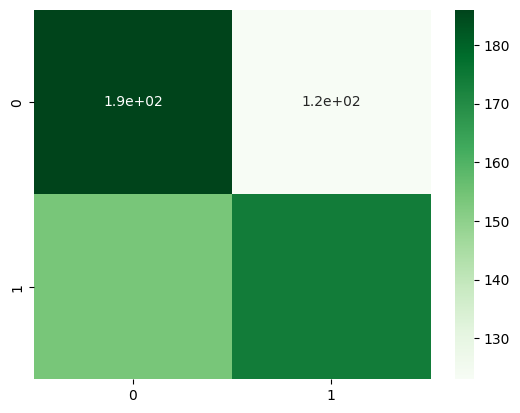

In [54]:
# confusion-matrix visualization
sns.heatmap(cm, annot=True, cmap='Greens')

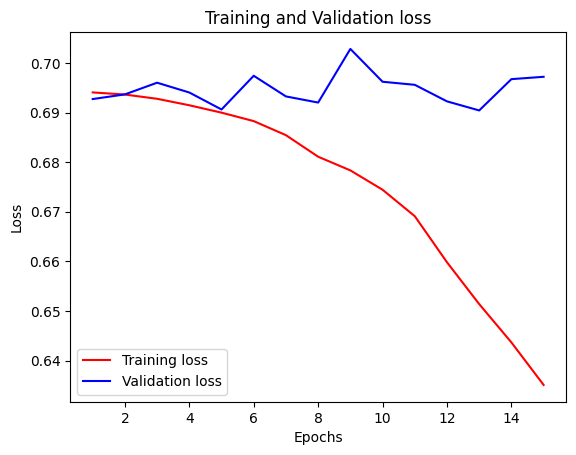

In [55]:
# visualization of loss over epochs
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()